<a href="https://colab.research.google.com/github/ricardodeazambuja/mmdetection/blob/master/MMDet_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMDetection Tutorial

Welcome to MMDetection! This is the official colab tutorial for using MMDetection. In this tutorial, you will learn
- Perform inference with a MMDet detector.
- Train a new detector with a new dataset.

Let's start!


## Install MMDetection

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# Check current verions available...
import torch, torchvision

torch_ver, cu_ver = torch.__version__.split("+")

print(f"Torch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")

Torch: 1.9.0+cu102
Torchvision: 0.10.0+cu102


Install mmcv-full according to the versions available

In [3]:
%%bash -s "$torch_ver" "$cu_ver"
echo "Installing mmcv-full for Torch $1 and CUDA $2"

# https://mmcv.readthedocs.io/en/latest/get_started/installation.html
pip install -q mmcv-full -f https://download.openmmlab.com/mmcv/dist/$2/torch$1/index.html

Installing mmcv-full for Torch 1.9.0 and CUDA cu102


Install MMDetection (clone github repo and install)

In [4]:
# Install mmdetection
!rm -rf mmdetection
!mkdir mmdetection
%cd mmdetection
!git init
!git remote add origin https://github.com/open-mmlab/mmdetection.git
!git fetch --depth 1 origin 31b3a58036de3a095837e21e810051451155821b # install specific commit
!git checkout FETCH_HEAD

!pip install -qe .

# install Pillow 7.0.0 back in order to avoid bug in colab
# !pip install Pillow==7.0.0

/content/mmdetection
Initialized empty Git repository in /content/mmdetection/.git/
remote: Enumerating objects: 1306, done.
remote: Counting objects: 100% (1306/1306), done.
remote: Compressing objects: 100% (877/877), done.
remote: Total 1306 (delta 518), reused 746 (delta 410), pack-reused 0
Receiving objects: 100% (1306/1306), 8.44 MiB | 33.12 MiB/s, done.
Resolving deltas: 100% (518/518), done.
From https://github.com/open-mmlab/mmdetection
 * branch            31b3a58036de3a095837e21e810051451155821b -> FETCH_HEAD
Note: checking out 'FETCH_HEAD'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 31b3a58 Add MobileNetv

In [5]:
pwd

'/content/mmdetection'

In [6]:
ls -la

total 140
drwxr-xr-x 16 root root  4096 Jul 26 15:00 ./
drwxr-xr-x  1 root root  4096 Jul 26 14:59 ../
drwxr-xr-x 73 root root  4096 Jul 26 14:59 configs/
drwxr-xr-x  2 root root  4096 Jul 26 14:59 demo/
drwxr-xr-x  2 root root  4096 Jul 26 14:59 .dev_scripts/
drwxr-xr-x  3 root root  4096 Jul 26 14:59 docker/
drwxr-xr-x  3 root root  4096 Jul 26 14:59 docs/
drwxr-xr-x  3 root root  4096 Jul 26 14:59 docs_zh-CN/
drwxr-xr-x  8 root root  4096 Jul 26 14:59 .git/
drwxr-xr-x  4 root root  4096 Jul 26 14:59 .github/
-rw-r--r--  1 root root  1317 Jul 26 14:59 .gitignore
-rw-r--r--  1 root root 11400 Jul 26 14:59 LICENSE
-rw-r--r--  1 root root   185 Jul 26 14:59 MANIFEST.in
drwxr-xr-x  7 root root  4096 Jul 26 14:59 mmdet/
drwxr-xr-x  2 root root  4096 Jul 26 15:00 mmdet.egg-info/
-rw-r--r--  1 root root  1870 Jul 26 14:59 model-index.yml
-rw-r--r--  1 root root  1169 Jul 26 14:59 .pre-commit-config.yaml
-rw-r--r--  1 root root   293 Jul 26 14:59 pytest.ini
-rw-r--r--  1 root root  8921 Jul 

In [7]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.9.0+cu102 True
2.14.0
10.2
GCC 7.3


## Perform inference with a MMDet detector
MMDetection already provides high level APIs to do inference and training.

In [56]:
import os.path
from yaml import load, dump
import requests

from PIL import Image

In [10]:
# List all available models

with open(f"model-index.yml", 'r') as ymlfile:
  available_models = load(ymlfile)['Import']

for i,mi in enumerate(available_models):
  print(f"{i:2d}", mi)

 0 configs/atss/metafile.yml
 1 configs/autoassign/metafile.yml
 2 configs/cascade_rcnn/metafile.yml
 3 configs/centernet/metafile.yml
 4 configs/centripetalnet/metafile.yml
 5 configs/cornernet/metafile.yml
 6 configs/dcn/metafile.yml
 7 configs/deformable_detr/metafile.yml
 8 configs/detectors/metafile.yml
 9 configs/detr/metafile.yml
10 configs/double_heads/metafile.yml
11 configs/dynamic_rcnn/metafile.yml
12 configs/empirical_attention/metafile.yml
13 configs/faster_rcnn/metafile.yml
14 configs/fcos/metafile.yml
15 configs/foveabox/metafile.yml
16 configs/fp16/metafile.yml
17 configs/fpg/metafile.yml
18 configs/free_anchor/metafile.yml
19 configs/fsaf/metafile.yml
20 configs/gcnet/metafile.yml
21 configs/gfl/metafile.yml
22 configs/ghm/metafile.yml
23 configs/gn/metafile.yml
24 configs/gn+ws/metafile.yml
25 configs/grid_rcnn/metafile.yml
26 configs/groie/metafile.yml
27 configs/guided_anchoring/metafile.yml
28 configs/hrnet/metafile.yml
29 configs/htc/metafile.yml
30 configs/instab

In [47]:
# Choose model config (index) to see what options are available:
model_config_idx = 45


model_config = available_models[model_config_idx]
with open(f"{model_config}", 'r') as ymlfile:
  m = load(ymlfile)
  for i,ci in enumerate(m['Models']):
    print(f"{i:2d}", ci['Config'])

 0 configs/retinanet/retinanet_r50_caffe_fpn_1x_coco.py
 1 configs/retinanet/retinanet_r50_fpn_1x_coco.py
 2 configs/retinanet/retinanet_r50_fpn_2x_coco.py
 3 configs/retinanet/retinanet_r101_caffe_fpn_1x_coco.py
 4 configs/retinanet/retinanet_r101_fpn_1x_coco.py
 5 configs/retinanet/retinanet_r101_fpn_2x_coco.py
 6 configs/retinanet/retinanet_x101_32x4d_fpn_1x_coco.py
 7 configs/retinanet/retinanet_x101_32x4d_fpn_2x_coco.py
 8 configs/retinanet/retinanet_x101_64x4d_fpn_1x_coco.py
 9 configs/retinanet/retinanet_x101_64x4d_fpn_2x_coco.py


In [48]:
# Choose a model by index:
model_idx = 9

# Check if the checkpoints dir already exists:
if not os.path.isdir(os.path.join(os.getcwd(),"checkpoints")):
  os.mkdir(os.path.join(os.getcwd(),"checkpoints"))

# Select the model according to the index
c = m['Models'][model_idx]

# Choose to use a config and initialize the detector
config = c['Config']

# Setup a checkpoint file to download
checkpoint_url = c['Weights']


# Only download the model if it is not available in the checkpoints dir:
if not os.path.isfile(os.path.join(os.getcwd(),checkpoint_url.split('/')[-1])):
  # Download weights
  print(f"Downloading {checkpoint_url}...")
  r = requests.get(checkpoint_url, allow_redirects=True)

  if r.status_code == 200:
    # Save file
    open(f"checkpoints/{checkpoint_url.split('/')[-1]}", 'wb').write(r.content)
    print("Weights saved!")
    del r
  else:
    print(f"Something went wrong with {checkpoint_url}")

Weights saved!


In [49]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# Setup a checkpoint file to load
checkpoint = f"checkpoints/{checkpoint_url.split('/')[-1]}"
# initialize the detector
model = init_detector(config, checkpoint, device='cuda:0')

/content/mmdetection/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


Use load_from_local loader


In [50]:
# Use the detector to do inference
img = 'demo/demo.jpg'
result = inference_detector(model, img)

/content/mmdetection/mmdet/datasets/utils.py:68: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
/content/mmdetection/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/content/mmdetection/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


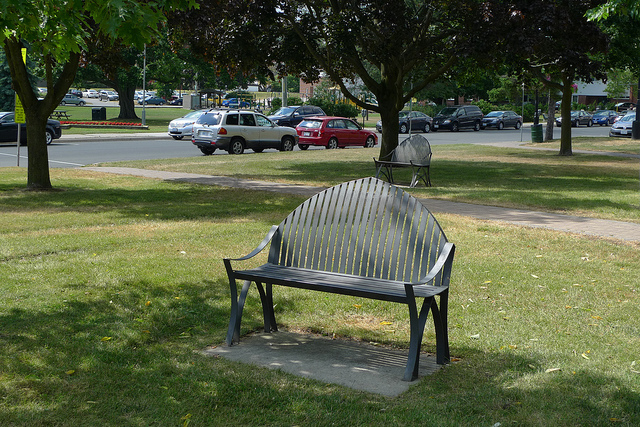

In [58]:
# Original image
Image.open(img)

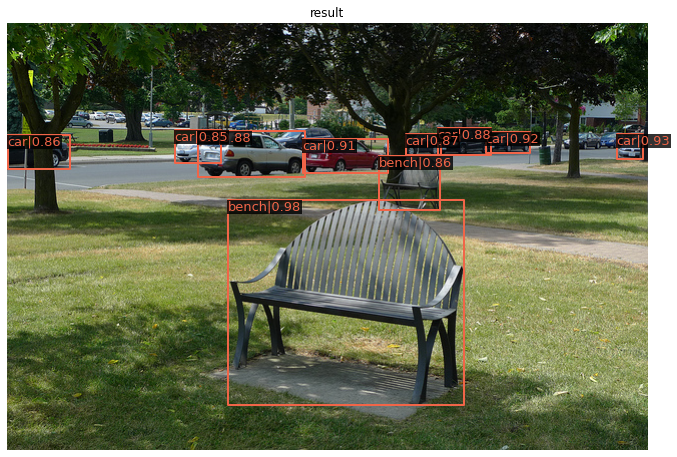

In [61]:
# Let's plot the result
show_result_pyplot(model, img, result, score_thr=0.8)

### Manually drawing bboxes

In [115]:
from PIL import Image, ImageDraw

In [79]:
# Classes available in this model
print([(i, ci) for i,ci in enumerate(model.CLASSES)])

[(0, 'person'), (1, 'bicycle'), (2, 'car'), (3, 'motorcycle'), (4, 'airplane'), (5, 'bus'), (6, 'train'), (7, 'truck'), (8, 'boat'), (9, 'traffic_light'), (10, 'fire_hydrant'), (11, 'stop_sign'), (12, 'parking_meter'), (13, 'bench'), (14, 'bird'), (15, 'cat'), (16, 'dog'), (17, 'horse'), (18, 'sheep'), (19, 'cow'), (20, 'elephant'), (21, 'bear'), (22, 'zebra'), (23, 'giraffe'), (24, 'backpack'), (25, 'umbrella'), (26, 'handbag'), (27, 'tie'), (28, 'suitcase'), (29, 'frisbee'), (30, 'skis'), (31, 'snowboard'), (32, 'sports_ball'), (33, 'kite'), (34, 'baseball_bat'), (35, 'baseball_glove'), (36, 'skateboard'), (37, 'surfboard'), (38, 'tennis_racket'), (39, 'bottle'), (40, 'wine_glass'), (41, 'cup'), (42, 'fork'), (43, 'knife'), (44, 'spoon'), (45, 'bowl'), (46, 'banana'), (47, 'apple'), (48, 'sandwich'), (49, 'orange'), (50, 'broccoli'), (51, 'carrot'), (52, 'hot_dog'), (53, 'pizza'), (54, 'donut'), (55, 'cake'), (56, 'chair'), (57, 'couch'), (58, 'potted_plant'), (59, 'bed'), (60, 'dini

In [112]:
# Get bboxes from results

import numpy as np

if isinstance(result, tuple):
    bbox_result, segm_result = result
    if isinstance(segm_result, tuple):
        segm_result = segm_result[0]  # ms rcnn
else:
    bbox_result, segm_result = result, None
bboxes = np.vstack(bbox_result)
labels = [
    np.full(bbox.shape[0], i, dtype=np.int32)
    for i, bbox in enumerate(bbox_result)
]
labels = np.concatenate(labels)

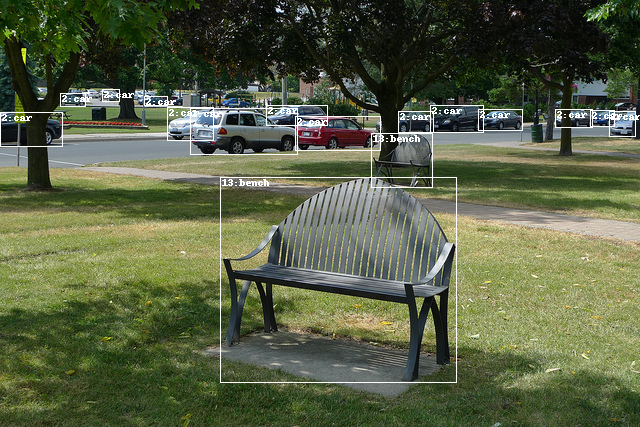

In [125]:
threshold = 0.5

img_test = Image.open(img)

# width, height = img_test.size

draw = ImageDraw.Draw(img_test)
for bbox, label in zip(bboxes.copy(), labels):
  if bbox[-1] >= threshold:
    draw.rectangle([bbox[0],bbox[1], bbox[2], bbox[3]])
    draw.text((bbox[0]+2,bbox[1]), f"{label}:{model.CLASSES[label]}")
img_test

## Train a detector on customized dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



### Support a new dataset

There are three ways to support a new dataset in MMDetection: 
  1. reorganize the dataset into COCO format.
  2. reorganize the dataset into a middle format.
  3. implement a new dataset.

Usually we recommend to use the first two methods which are usually easier than the third.

In this tutorial, we gives an example that converting the data into the format of existing datasets like COCO, VOC, etc. Other methods and more advanced usages can be found in the [doc](https://mmdetection.readthedocs.io/en/latest/tutorials/new_dataset.html#).

Firstly, let's download a tiny dataset obtained from [KITTI](http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d). We select the first 75 images and their annotations from the 3D object detection dataset (it is the same dataset as the 2D object detection dataset but has 3D annotations). We convert the original images from PNG to JPEG format with 80% quality to reduce the size of dataset.

In [ ]:
# download, decompress the data
!wget https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null

--2020-07-13 14:48:40--  https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/data/kitti_tiny.zip
Resolving open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)... 52.219.56.23
Connecting to open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)|52.219.56.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: ‘kitti_tiny.zip’

kitti_tiny.zip      100%[===================>]   6.60M  8.02MB/s    in 0.8s    

2020-07-13 14:48:41 (8.02 MB/s) - ‘kitti_tiny.zip’ saved [6918271/6918271]



In [ ]:
# Check the directory structure of the tiny data

# Install tree first
!apt-get -q install tree
!tree kitti_tiny

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 33 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 1s (46.7 kB/s)
Selecting previously unselected package tree.
(Reading database ... 144379 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
kitti_tiny
├── training
│   ├── image_2
│   │   ├── 000000.jpeg
│   │   ├── 000001.jpeg
│   │   ├── 000002.jpeg
│   │   ├── 000003.jpeg
│   │   ├── 000004.jpe

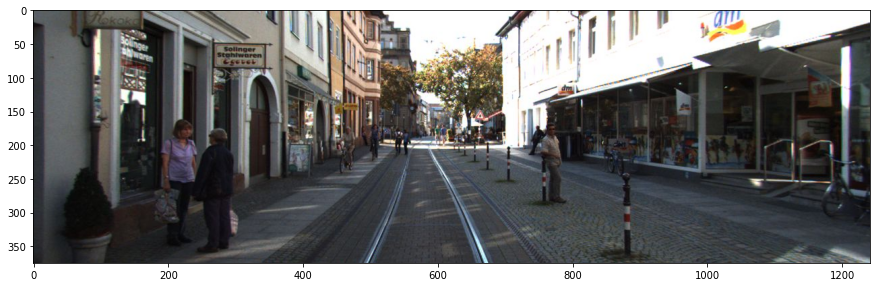

In [ ]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('kitti_tiny/training/image_2/000073.jpeg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

After downloading the data, we need to implement a function to convert the kitti annotation format into the middle format. In this tutorial we choose to convert them in **`load_annotations`** function in a newly implemented **`KittiTinyDataset`**.

Let's take a loot at the annotation txt file.



In [ ]:
# Check the label of a single image
!cat kitti_tiny/training/label_2/000000.txt

Pedestrian 0.00 0 -0.20 712.40 143.00 810.73 307.92 1.89 0.48 1.20 1.84 1.47 8.41 0.01


According to the KITTI's documentation, the first column indicates the class of the object, and the 5th to 8th columns indicates the bboxes. We need to read annotations of each image and convert them into middle format MMDetection accept is as below:

```python
[
    {
        'filename': 'a.jpg',
        'width': 1280,
        'height': 720,
        'ann': {
            'bboxes': <np.ndarray> (n, 4),
            'labels': <np.ndarray> (n, ),
            'bboxes_ignore': <np.ndarray> (k, 4), (optional field)
            'labels_ignore': <np.ndarray> (k, 4) (optional field)
        }
    },
    ...
]
```

In [ ]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class KittiTinyDataset(CustomDataset):

    CLASSES = ('Car', 'Pedestrian', 'Cyclist')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpeg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpeg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('image_2', 'label_2')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[4:8]] for x in content]
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [ ]:
from mmcv import Config
cfg = Config.fromfile('./configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')

Given a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset.

In [ ]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'KittiTinyDataset'
cfg.data_root = 'kitti_tiny/'

cfg.data.test.type = 'KittiTinyDataset'
cfg.data.test.data_root = 'kitti_tiny/'
cfg.data.test.ann_file = 'train.txt'
cfg.data.test.img_prefix = 'training/image_2'

cfg.data.train.type = 'KittiTinyDataset'
cfg.data.train.data_root = 'kitti_tiny/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image_2'

cfg.data.val.type = 'KittiTinyDataset'
cfg.data.val.data_root = 'kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 3
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='FasterRCNN',
    pretrained='open-mmlab://detectron2/resnet50_caffe',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        los

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

2020-07-13 14:49:11,873 - mmdet - INFO - load model from: open-mmlab://detectron2/resnet50_caffe
Downloading: "https://open-mmlab.s3.ap-northeast-2.amazonaws.com/pretrain/third_party/resnet50_msra-5891d200.pth" to /root/.cache/torch/checkpoints/resnet50_msra-5891d200.pth


2020-07-13 14:49:16,377 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: conv1.bias



2020-07-13 14:49:16,729 - mmdet - INFO - load checkpoint from checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
2020-07-13 14:49:16,864 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([4]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([12, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([12]).
unexpected key in source state_dict: roi_head.mask_head.conv

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 10.9 task/s, elapsed: 2s, ETA:     0s

2020-07-13 14:51:32,234 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 62  | 142  | 0.968  | 0.871 |
| Pedestrian | 13  | 56   | 0.846  | 0.761 |
| Cyclist    | 7   | 63   | 0.429  | 0.035 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.555 |
+------------+-----+------+--------+-------+
2020-07-13 14:51:32,237 - mmdet - INFO - Epoch [12][25/25]	lr: 2.500e-05, mAP: 0.5553


### Understand the log
From the log, we can have a basic understanding the training process and know how well the detector is trained.

Firstly, the ResNet-50 backbone pre-trained on ImageNet is loaded, this is a common practice since training from scratch is more cost. The log shows that all the weights of the ResNet-50 backbone are loaded except the `conv1.bias`, which has been merged into `conv.weights`.

Second, since the dataset we are using is small, we loaded a Mask R-CNN model and finetune it for detection. Because the detector we actually using is Faster R-CNN, the weights in mask branch, e.g. `roi_head.mask_head`, are `unexpected key in source state_dict` and not loaded.
The original Mask R-CNN is trained on COCO dataset which contains 80 classes but KITTI Tiny dataset only have 3 classes. Therefore, the last FC layer of the pre-trained Mask R-CNN for classification has different weight shape and is not used.

Third, after training, the detector is evaluated by the default VOC-style evaluation. The results show that the detector achieves 54.1 mAP on the val dataset,
 not bad!

## Test the trained detector

After finetuning the detector, let's visualize the prediction results!

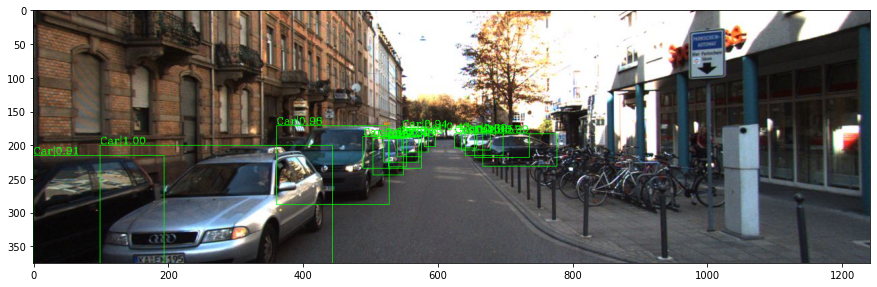

In [ ]:
img = mmcv.imread('kitti_tiny/training/image_2/000068.jpeg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)
